In [254]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [255]:
points_center_img = []
points_right_img = []
points_left_img = []

In [256]:
center_image = plt.imread('./images/center.jpg')
right_image = plt.imread('./images/right.jpg')
left_image = plt.imread('./images/left.jpg')

In [257]:
def resize_image(image, max_width=600):
    ratio = max_width / image.shape[1]
    new_height = int(image.shape[0] * ratio)
    resized_image = cv2.resize(image, (max_width, new_height))
    return resized_image

def get_points(event, x, y, flags, params):
    if event == cv2.EVENT_LBUTTONDOWN:
        orig_x = int(x / (resized_img.shape[1] / img.shape[1]))
        orig_y = int(y / (resized_img.shape[0] / img.shape[0]))
        params.append((orig_x, orig_y))
        cv2.circle(resized_img, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow('Select Points', resized_img)

def select_points(image_path, points_list):
    global img, resized_img
    img = cv2.imread(image_path)
    resized_img = resize_image(img)
    cv2.imshow('Select Points', resized_img)
    cv2.setMouseCallback('Select Points', get_points, points_list)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [258]:
select_points('./images/center.jpg', points_center_img)
select_points('./images/right.jpg', points_right_img)
select_points('./images/left.jpg', points_left_img)

In [259]:
print("Center Image Points:", points_center_img)
print("Right Image Points:", points_right_img)
print("Left Image Points:", points_left_img)

Center Image Points: [(1925, 2782), (1849, 3220), (1733, 3200), (1249, 3210), (1471, 1214)]
Right Image Points: [(1144, 2827), (1053, 3286), (947, 3281), (408, 3346), (675, 1239)]
Left Image Points: [(2923, 2842), (2837, 3311), (2696, 3286), (2147, 3240), (2353, 1169)]


In [260]:
def find_homography(src, dst):
    n_points = src.shape[0]
    A = np.zeros((2 * n_points, 9))
    for i in range(n_points):
        x, y = src[i]
        x_prime, y_prime = dst[i]
        A[2*i] = [x, y, 1, 0, 0, 0, -x_prime*x, -x_prime*y, -x_prime]
        A[2*i + 1] = [0, 0, 0, x, y, 1, -y_prime*x, -y_prime*y, -y_prime]
    U, S, V_t = np.linalg.svd(A)
    H = V_t[-1].reshape(3, 3)
    H = H / H[2, 2]
    return H

In [261]:
points_center_img = np.array(points_center_img, dtype='float32')
points_right_img = np.array(points_right_img, dtype='float32')
points_left_img = np.array(points_left_img, dtype='float32')

h1= find_homography(points_left_img, points_center_img)
h2 = find_homography(points_right_img, points_center_img)

In [262]:
print(h1)
print(h2)

[[ 1.39269081e+00 -3.53333373e-02 -1.27206375e+03]
 [ 3.54381088e-01  1.24335042e+00 -6.67181624e+02]
 [ 1.47038181e-04 -9.61839552e-06  1.00000000e+00]]
[[ 7.90105011e-01  2.16020153e-02  8.57296811e+02]
 [-1.26519736e-01  9.55455017e-01  7.20008048e+01]
 [-7.10053305e-05  9.43417354e-06  1.00000000e+00]]


In [263]:
def stitch_images(img1, img2, H):
    """
    Stitches img1 and img2 using the given Homography matrix H.
    img1 is transformed and stitched to img2.
    """
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    corners2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    transformed_corners = cv2.perspectiveTransform(corners1, H)
    all_corners = np.concatenate((corners2, transformed_corners), axis=0)

    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
    
    translation_dist = [-x_min, -y_min]
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
    result = cv2.warpPerspective(img1, H_translation.dot(H), (x_max - x_min, y_max - y_min))
    result[translation_dist[1]:translation_dist[1]+h2, translation_dist[0]:translation_dist[0]+w2] = img2

    return result

In [267]:
left_img = cv2.imread('./images/left.jpg')
center_img = cv2.imread('./images/center.jpg')
right_img = cv2.imread('./images/right.jpg')

img1 = stitch_images(left_img, center_img, h1)
img1 = cv2.resize(img1, (350, 350), interpolation = cv2.INTER_AREA)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

In [268]:
img2 = stitch_images(right_img, center_img, h2)
img2 = cv2.resize(img2, (350, 350), interpolation=cv2.INTER_AREA)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

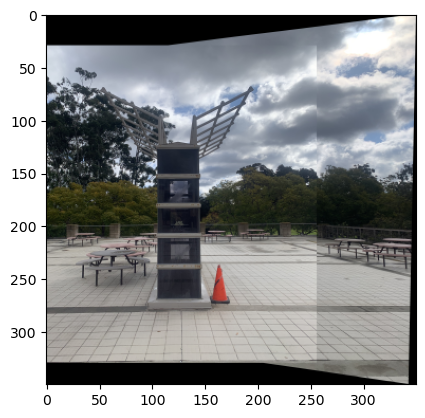

In [269]:
plt.imshow(img2)
plt.show()

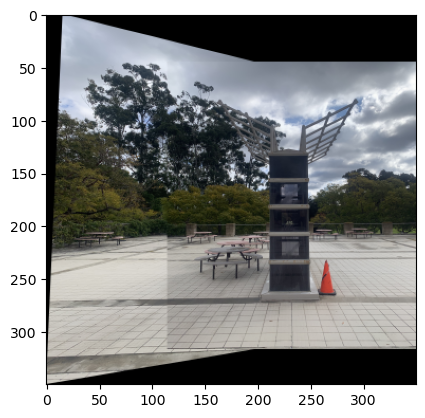

In [270]:
plt.imshow(img1)
plt.show()

# TODO: TRY WITH 6 OR 7 POINTS THE HOMOGRAPHIES, IN DIFFERENT PLACES.

In [271]:
def warp_imgs(imgs, homos):
    # This function will warp the images and create the offsets so they are visible
    
    x_m, y_m, x_mx, y_mx = float('inf'), float('inf'), float('-inf'), float('-inf')
    for img, H in zip(imgs, homos):
        h, w = img.shape[:2]
        corners = np.array([[0, 0], [0, h], [w, h], [w, 0]], dtype=np.float32).reshape(-1, 1, 2)
        wcornerss = cv2.perspectiveTransform(corners, H)
        x_m = min(x_m, np.min(wcornerss[:, :, 0]))
        y_m = min(y_m, np.min(wcornerss[:, :, 1]))
        x_mx = max(x_mx, np.max(wcornerss[:, :, 0]))
        y_mx = max(y_mx, np.max(wcornerss[:, :, 1]))
        

    w = int(np.ceil(x_mx - x_m))
    h = int(np.ceil(y_mx - y_m))
    off_x, off_y = -x_m, -y_m

    res = np.zeros((h, w, 3), dtype=np.uint8)
    for img, H in zip(imgs, homos):
        H_off = np.array([[1, 0, off_x], [0, 1, off_y], [0, 0, 1]]) @ H
        warped = cv2.warpPerspective(img, H_off, (w, h))
        mask = (warped > 0)
        res[mask] = warped[mask]
    return res


def panoramic_image(center, left, right, H1, H2):
    H_copy = np.eye(3) 
    imgs = [left, center, right]
    homos = [H1, H_copy, H2]
    panoram = warp_imgs(imgs, homos)
    return panoram


In [272]:
left_img = cv2.imread('./images/left.jpg')
center_img = cv2.imread('./images/center.jpg')
right_img = cv2.imread('./images/right.jpg')

In [273]:
img_panoram = panoramic_image(center_img, left_img, right_img, h1, h2)

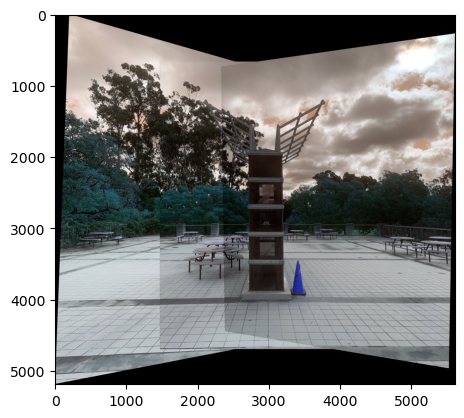

In [274]:
plt.imshow(img_panoram)
plt.show()